In [249]:
from sklearn.datasets import make_classification
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime

from examine_explanation import examine_interpretation
from examine_explanation import examine_local_fidelity
from examine_explanation import get_lipschitz
from examine_explanation import get_lipschitz

# Fidelity


### Create synthetic dataset

In [250]:
n_features = 4
X, y = make_classification(n_samples=1000, n_informative=2, n_features=n_features, n_redundant=2)
X = preprocessing.normalize(X)
X=pd.DataFrame(data=X)

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### XGB Model

In [252]:
X_train.columns = ['0','1','2','3']
X_test.columns = ['0','1','2','3']
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
#xgb_model.get_booster().feature_names = X_train.columns
xgb_preds = xgb_model.predict(X_test)
print(accuracy_score(y_test, xgb_preds))

print(classification_report(y_test, xgb_preds))

0.8848484848484849
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       173
           1       0.87      0.89      0.88       157

    accuracy                           0.88       330
   macro avg       0.88      0.89      0.88       330
weighted avg       0.89      0.88      0.88       330



## Random forest

In [253]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
sklearn.metrics.accuracy_score(y_test, rf.predict(X_test))

0.8484848484848485

### Get interpretation importances

In [254]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from pdpbox import pdp, get_dataset, info_plots
import shap
import lime

shap.initjs()

# Preturbation based on permutation importances

In [255]:
perm = PermutationImportance(xgb_model, random_state=1).fit(X_test, y_test)
perm_importances = perm.feature_importances_
feature_names = [str(i) for i in range(n_features)]
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.2842 ± 0.0384,2
0.0230 ± 0.0106,1
-0.0055 ± 0.0045,0
-0.0067 ± 0.0140,3


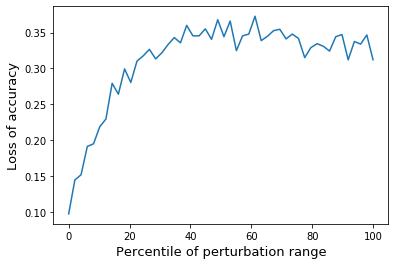

In [257]:
preturbed_perm_accuraties = examine_interpretation(xgb_model, X_test, y_test, perm_importances, epsilon=4, resolution=50, proportionality_mode=0)

# Perturbation based on local importances

### SHAP

[0.08969696969696972,
 0.15030303030303027,
 0.21757575757575764,
 0.2709090909090909,
 0.3145454545454546,
 0.31939393939393934,
 0.30606060606060603,
 0.3224242424242425,
 0.3272727272727274,
 0.3151515151515153]

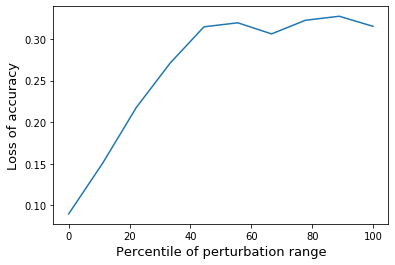

In [258]:
examine_local_fidelity(xgb_model, X_test, y_test, epsilon=3)

### LIME

[0.2987878787878787,
 0.31272727272727274,
 0.3406060606060606,
 0.3654545454545455,
 0.4181818181818182,
 0.40666666666666673,
 0.42181818181818187,
 0.42181818181818187,
 0.4321212121212122,
 0.4054545454545455]

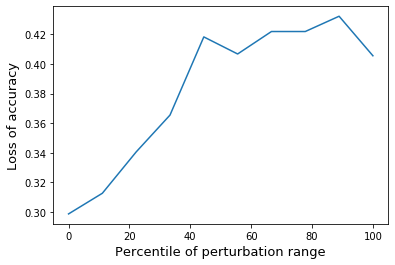

In [259]:
examine_local_fidelity(rf, X_test, y_test, epsilon=3,framework='lime' )

# Preturbation based on shapley values

In [260]:
xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X_test)

In [261]:
shap_imps = []
transposed_shap = [*zip(*xgb_shap_values)]
for idx, col in enumerate(transposed_shap):
    shap_imps.append(np.mean(list(map(lambda x: abs(x), col))))

In [262]:
abs_importances = list(map(abs, shap_imps))
total_importance = (sum(abs_importances))
importance_shares = list(map(lambda x: x/total_importance, abs_importances))

max_importance = max(shap_imps)
reversed_importances = list(map(lambda x: max_importance - x, abs_importances))
total_reversed_importance = (sum(reversed_importances))
inverse_importance_shares = list(map(lambda x: x/total_reversed_importance, reversed_importances))

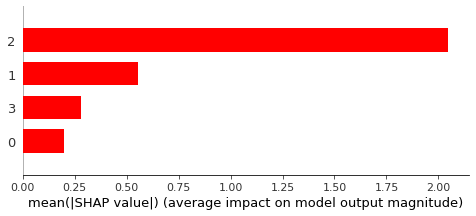

In [263]:
shap.summary_plot(xgb_shap_values, X_test, plot_type="bar", color='red')

Text(0, 0.5, 'Share of feature to be perturbed')

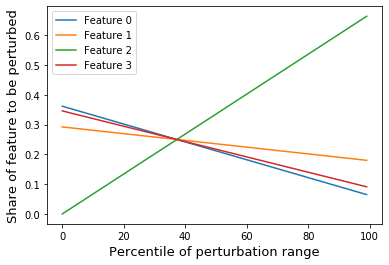

In [264]:
for i in range(len(importance_shares)):
    d=np.linspace(inverse_importance_shares[i], importance_shares[i],100)
    plt.plot(d)
    print
plt.legend(['Feature 0', 'Feature 1', 'Feature 2', 'Feature 3'])
plt.xlabel('Percentile of perturbation range', fontsize=13)
plt.ylabel('Share of feature to be perturbed', fontsize=13)
   

## Mode 0

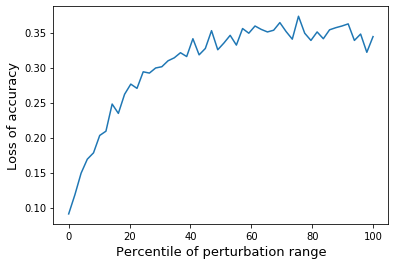

In [265]:
preturbed_shap_accuracies = examine_interpretation(xgb_model, X_test, y_test, shap_imps, epsilon=4, resolution=50)

## Mode 1

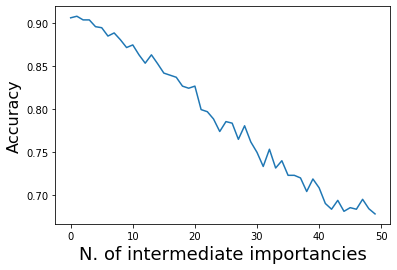

In [179]:
preturbed_shap_accuracies = examine_interpretation(xgb_model, X_test, y_test, shap_imps, epsilon=2, resolution=50, proportionality_mode=1)

# Test for dataset without noise features

In [84]:
newx, newy = make_classification(n_samples=1000, n_informative=2, n_features=2, n_redundant=0)
newx = preprocessing.normalize(newx)
newx=pd.DataFrame(data=newx)

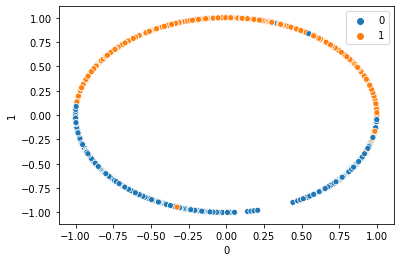

In [85]:
sns.scatterplot(x=newx[0],y=newx[1],hue=newy)

In [86]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(newx, newy, test_size=0.33, random_state=42)

In [87]:
xgb_model2 = xgb.XGBClassifier()
xgb_model2.fit(X_train2, y_train2)
xgb_preds2 = xgb_model2.predict(X_test2)
print(accuracy_score(y_test2, xgb_preds2))

print(classification_report(y_test2, xgb_preds2))

0.9575757575757575
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       173
           1       0.96      0.96      0.96       157

    accuracy                           0.96       330
   macro avg       0.96      0.96      0.96       330
weighted avg       0.96      0.96      0.96       330



## Permutation importances

In [88]:
perm2 = PermutationImportance(xgb_model2, random_state=1).fit(X_test2, y_test2)
perm_importances2 = perm2.feature_importances_
eli5.show_weights(perm2)

Weight,Feature
0.4648 ± 0.0533,x1
0.0145 ± 0.0071,x0


## Mode 0

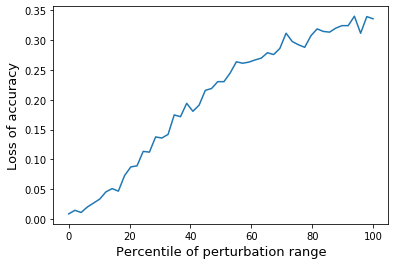

In [89]:
preturbed_perm_accuraties2 = examine_interpretation(xgb_model2, X_test2, y_test2, perm_importances2, epsilon=2, resolution=50, proportionality_mode=0)

# Mode 1

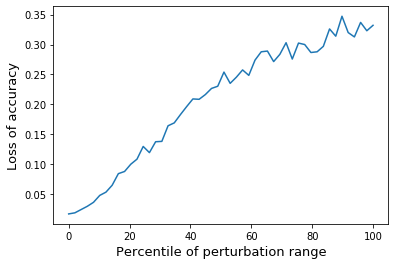

In [90]:
preturbed_perm_accuraties2 = examine_interpretation(xgb_model2, X_test2, y_test2, perm_importances2, epsilon=2, resolution=50, proportionality_mode=1)

In [ ]:
shap_imps2 = []
transposed_shap2 = [*zip(*xgb_shap_values2)]
for idx, col in enumerate(transposed_shap2):
    shap_imps2.append(np.mean(list(map(lambda x: abs(x), col))))

In [ ]:
shap.summary_plot(xgb_shap_values2, X_test2, plot_type="bar", color='red')

## Mode 0

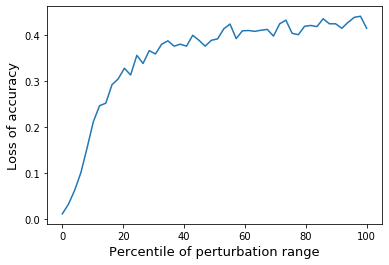

In [96]:
preturbed_shap_accuracies2 = examine_interpretation(xgb_model2, X_test2, y_test2, shap_imps2, epsilon=10, resolution=50)

## Mode 1

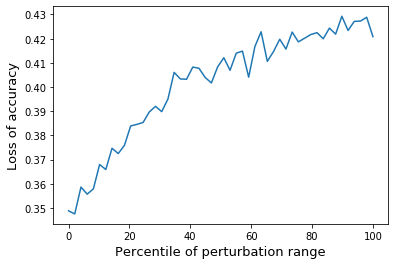

In [97]:
preturbed_shap_accuracies2 = examine_interpretation(xgb_model2, X_test2, y_test2, shap_imps2, epsilon=10, resolution=50, proportionality_mode=1, count_per_step=50)

In [196]:
lime_lips = get_lipschitz(rf, X_test, epsilon=3, framework='lime')

[[ 1.17546822e-02 -1.30943964e-01 -2.78743087e-01  3.49540849e-04]
 [ 1.42130322e-02  7.66759283e-03 -2.73606372e-01 -9.71953597e-02]
 [ 1.54008136e-02 -1.20296988e-01 -2.62675745e-01 -1.39195474e-04]
 [-9.71626540e-03  2.04673694e-01  2.28930023e-01 -2.57126934e-02]
 [ 9.66487829e-04 -1.21458188e-01 -2.74844548e-01  1.45730188e-04]
 [-4.21090323e-04 -7.29213459e-02  2.80843540e-01  1.43661119e-01]
 [ 9.10077382e-03 -1.14024520e-01 -2.64542635e-01 -5.48622969e-03]
 [ 3.88392547e-03 -2.28034657e-02 -2.72566446e-01 -1.15939013e-01]
 [ 4.32588414e-03  2.03897448e-01  2.22571304e-01 -1.11674470e-01]
 [ 5.36240012e-03 -6.56532940e-02  2.43148697e-01  1.45017571e-01]
 [-2.37966211e-02 -7.76700998e-02 -2.63880966e-01 -1.12246683e-01]
 [-1.17764017e-02 -1.26013206e-01 -2.54393289e-01 -4.13238306e-02]
 [-2.60952938e-02 -9.80387674e-02 -2.56188085e-01 -3.29762978e-02]
 [-1.22616996e-02  2.15460532e-01  2.82016871e-01  9.28668055e-03]
 [-1.38667848e-02  2.07532194e-01  2.84884551e-01 -3.72371079e

IndexError: index 243 is out of bounds for axis 0 with size 100

In [206]:
shap_lips = get_lipschitz(rf, X_test.iloc[:12], epsilon=3, sample_num=5)


[[ 3.18191713e-03 -2.72565365e-01 -3.77261329e+00  4.47581634e-02]
 [-3.57461303e-01 -5.36049008e-01 -4.20499945e+00 -6.77878201e-01]
 [-3.65294278e-01 -5.73013067e-01 -4.87416887e+00 -6.77878201e-01]
 [ 2.14113668e-01 -1.08921087e+00  4.51578093e+00 -1.95416883e-01]
 [-5.88150434e-02  5.72169662e-01 -4.26717234e+00  2.84121502e-02]
 [ 1.37183771e-01 -5.14920689e-02  4.22266722e+00  2.07644865e-01]
 [ 1.52463943e-01  2.30985731e-01  4.29153967e+00  9.19026732e-02]
 [-3.65294278e-01 -5.73013067e-01 -4.87416887e+00 -6.77878201e-01]
 [ 3.18191713e-03 -2.72565365e-01 -3.77261329e+00  4.47581634e-02]
 [ 4.45126817e-02 -3.68521661e-02 -3.34837794e+00 -1.96008250e-01]
 [ 2.15716168e-01  2.18294680e-01  5.11283684e+00 -1.81354314e-01]
 [ 3.05951446e-01 -1.62259303e-02 -2.74690652e+00 -1.15966825e-02]]
<class 'numpy.ndarray'>
[0, 6, 11, 1, 3, 10, 2, 9, 8, 4, 5, 7]
<class 'list'>


/Users/hook/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


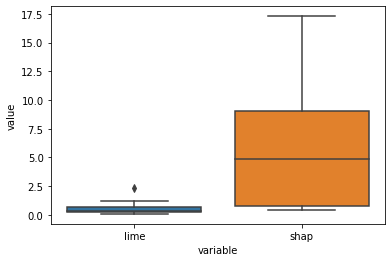

In [209]:
lip_df = pd.DataFrame({'lime':lime_lips, 'shap':shap_lips})
sns.boxplot(x="variable", y="value", data=pd.melt(lip_df))

In [291]:
m1_forest = sklearn.ensemble.RandomForestClassifier(n_estimators=50)
m1_forest.fit(X_train, y_train)
#sklearn.metrics.accuracy_score(y_test, rf.predict(X_test))

m2_xgb = xgb.XGBClassifier()
m2_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [304]:
cvals = check_consistency([m1_forest, m2_xgb], X_test, y_test, sample_num = 10)

[2.653676364832917,
 2.0886000511285894,
 2.6976705846749702,
 2.798752851195027,
 1.3156238499198858,
 3.077254759674347,
 2.7033008131174707,
 2.572408703435377,
 2.3774594633893336,
 2.52919102987004]